# Project 2: Mini deep-learning framework

In [1]:
import matplotlib.pyplot as plt #To remove (use matplotlib)
from torch import empty
import numpy as np
import math
# import torch.nn as nn

# from torch.autograd import Variable
# from torch.nn import functional as F
import torch
torch.set_grad_enabled(False)

## Data generation

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
Sanity check:  tensor(1000.)  /  1000
Sanity check:  tensor(1000.)  /  1000


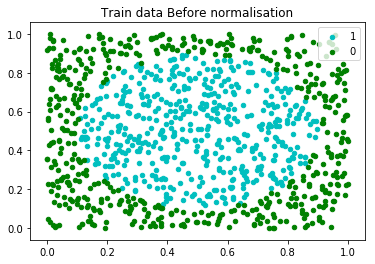

Point outside:  504
Point inside:   496


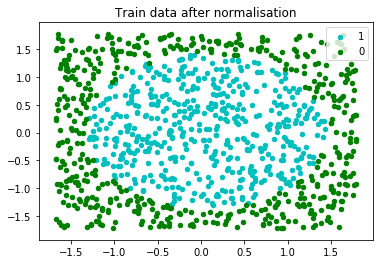

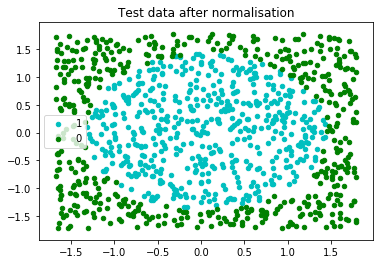

In [2]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    Y[:,0] = ( (X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    Y[:,1] = ( (X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    return(X, Y)

Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)

print(train_target[0:10,:])
print("Sanity check: ", train_target.sum(), " / ", train_target.size(0))
print("Sanity check: ", test_target.sum(), " / ", test_target.size(0))

plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data Before normalisation")
plt.legend(["1", "0"] )
plt.show()

print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))


mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target[:,1]==1),0] ,test_input[(test_target[:,1]==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target[:,1]==0),0] ,test_input[(test_target[:,1]==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


## Classic Structure

# Module

In [3]:
class Module( ):
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

## Non linearity

In [4]:
class Activation(Module):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

class Tanh(Activation):
    def __init__(self):
        Activation.__init__(self)
        
    def forward(self, x):
        self.s = x
        return x.tanh()

    def backward(self, *gradwrtoutput):
        return (1 - (self.s.tanh()).pow(2)) * (gradwrtoutput[0])
        
    def param(self):
        return []
    
    
class Relu(Activation):
    def __init__(self):
        Activation.__init__(self)
    
    def forward(self, x):
        self.s = x
        
        y = empty(self.s.size()).zero_()
        y[x>0] = x[x>0]
        
        return y

    def backward(self, *gradwrtoutput):
        y = empty(gradwrtoutput[0].size()).zero_()
        y[self.s > 0] = gradwrtoutput[0][self.s > 0]
        
        return y

    def param(self):
        return []


class Sigmoid(Activation):
    def __init__(self, p_lambda):
        Activation.__init__(self)
        self.p_lambda = p_lambda
    
    def forward(self, x):
        self.s = x
        return 1/(1 + (-self.p_lambda*x).exp())

    def backward(self, *gradwrtoutput):
        return (-self.s * self.p_lambda).exp() / ((-self.s * self.p_lambda).exp() + 1).pow(2)

    def param(self):        
        return []


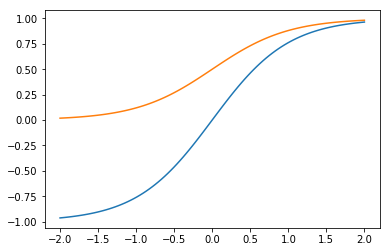

In [5]:
x = torch.linspace(-2,2,100)


tanh_1 = Tanh()
y_tan = tanh_1.forward(x)
plt.plot(x.numpy(), y_tan.numpy())
# plt.show()
a = tanh_1.backward(x)

relu_1 = Relu()
y_relu = relu_1.forward(x)
grad = relu_1.backward(y_relu)                       
# plt.plot(x.numpy(), y_relu.numpy())
# plt.show()

sigmoid_1 = Sigmoid(2)
y_sigmoid = sigmoid_1.forward(x)
grad = sigmoid_1.backward(y_sigmoid)                       
plt.plot(x.numpy(), y_sigmoid.numpy())
# plt.show()




## Loss

In [6]:
class Loss(Module):
    def __init__(self):
        output = empty((0,0))
        target_output = empty((0,0))
    
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

    
class LossMSE(Loss):   
    def __init__(self):
        Loss.__init__(self)
    
    def forward( self , output, target_output ):
        self.output = output
        self.target_output = target_output
        loss = (output - target_output).pow(2).mean()  # (dim=0).sum()
        return loss


    def backward ( self ):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param ( self ) :
        return []
    
class CrossEntropy(Loss):
    def __init__(self):
        Loss.__init__(self)
    
    def forward( self , output, target_output ):
        self.output = output
        self.target_output = target_output
        loss =  -1./output.size(dim=0) * ( output[ (torch.arange(0, output.size(dim=0) )).type(torch.long), target_output ].sum() - output.exp().sum(dim=1).log().sum() ) 
        return loss
        
    def backward(self):
        grad = empty(self.output.size())
        for i in range(0, self.output.size(dim=0)):
            grad[i,:] = self.output[i,:].exp().div_( self.output[i,:].exp().sum())
       
        grad[(torch.arange(0, self.output.size(dim=0))).type(torch.long), self.target_output] -= 1
        grad.div_(self.output.size(dim=0))
        return grad
            

    def param(self):
        return []

In [7]:

A = torch.tensor([[1., 0, 2, 4], [1, 3, 4,4]])
target_A = torch.tensor([0,3])

our_cross = CrossEntropy()
print(our_cross.forward(A, target_A.type(torch.long)))

print(our_cross.backward())
print( -1./2*( 1 - A[0,0].exp()/(A[0,:].exp().sum())  ) )






tensor(2.0340)
tensor([[-0.4793,  0.0076,  0.0562,  0.4155],
        [ 0.0103,  0.0761,  0.2068, -0.2932]])
tensor(-0.4793)


## Linear

In [8]:
class Linear(Module): 
    
    def __init__(self, weight_size, bias_size):
        self.bias = empty(bias_size)
        self.weight = empty(weight_size)
        x = empty((0,0))
        s = empty((0,0))
        gradwrtbias = empty((0,0))
        gradwrtweight = empty((0,0))
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def define_parameters(self, weight, bias):
        self.weight = weight
        self.bias = bias.view((1, bias.numel()))
        
    
    def forward( self , *input ):
        x = input[0]
        self.x = x
        self.s = torch.mm(x, self.weight.t()) + self.bias
        return self.s

    def backward( self , *gradwrtoutput ):
        gradwrtoutput = gradwrtoutput[0]
        self.gradwrtbias = torch.mm(torch.ones((1, self.x.size(dim=0))) ,gradwrtoutput)
        self.gradwrtweight = torch.mm(gradwrtoutput.t(), self.x)
        return torch.mm(gradwrtoutput, self.weight)
        
    def update_parameters(self, eta):
        self.bias -= eta * self.gradwrtbias
        self.weight -= eta * self.gradwrtweight
        
    def param ( self ) :
        return [self.bias, self.weight]

In [9]:
A = torch.tensor([1.,2])
print(A.size())

torch.Size([2])


# Sequential

## Compute number error

In [10]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

In [11]:
A = torch.tensor([[1,2],[3,2],[10,0]])
B = torch.tensor([1,1,1])

print((A.argmax(dim=1) != B).sum())

tensor(2)


# Test 

In [12]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = CrossEntropy()


## MODEL BACKWARD PASS
def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    
    #print(x[0:4,:])
    l = loss.forward(x, target_x.argmax(dim=1))
    return (x, l)  
    


## MODEL BACKWARD PASS
passes = [loss, linear_4, relu_3, linear_3, relu_2, linear_2, relu_1, linear_1]

def model_backward(passes, eta):
    grad = passes[0].backward()
    for i in range(1, len(passes)):
        grad = passes[i].backward(grad)
        if passes[i].param():    #If we have parameters
            passes[i].update_parameters(eta)
            
    
    return(grad)
    



In [33]:
#Model iteration
std = 0.1
linear_1.normalize_parameters(mean=0, std=std)
linear_2.normalize_parameters(mean=0, std=std)
linear_3.normalize_parameters(mean=0, std=std)
linear_4.normalize_parameters(mean=0, std=std)
eta = 3e-1
batch_size = 200
epochs_number = 2000

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        _, loss_value = model_forward(train_input.narrow(0, b, batch_size), train_target.narrow(0, b, batch_size)) #.narrow(0, b, batch_size)
        model_backward(passes, eta)
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95
    
        




0 :  0.6998006105422974
50 :  0.07090804725885391
100 :  0.06067260727286339
150 :  0.02956848032772541
200 :  0.022872313857078552
250 :  0.020280761644244194
300 :  0.018579712137579918
350 :  0.16637083888053894
400 :  0.015227660536766052
450 :  0.012528075836598873
500 :  0.011799315921962261
550 :  0.026944579556584358
600 :  0.013070068322122097
650 :  0.012213134206831455
700 :  0.015043945051729679
750 :  0.014903564006090164
800 :  0.014974365010857582
850 :  0.015029296278953552
900 :  0.015211181715130806
950 :  0.014960937201976776
1000 :  0.015128173865377903
1050 :  0.014821777120232582
1100 :  0.01308593712747097
1150 :  0.015046386048197746
1200 :  0.013983153738081455
1250 :  0.012082519009709358
1300 :  0.01080322265625
1350 :  0.009919432923197746
1400 :  0.009486083872616291
1450 :  0.00881347618997097
1500 :  0.00823242124170065
1550 :  0.007791747804731131
1600 :  0.008312988094985485
1650 :  0.007846679538488388
1700 :  0.0074438476003706455
1750 :  0.0070825195

In [34]:
# Test set: 

output, l = model_forward(test_input, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")

# print(output[0:10,:])
# print(test_target[0:10,:])


 
Loss:  0.0470263697206974
Number of errors:  17

 


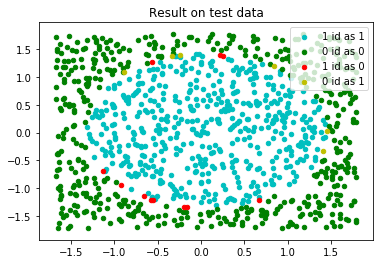

In [37]:
id_class = output.argmax(dim=1)

one_id_as_one = torch.mul( (test_target[:,1]==1), (id_class ==1 ))
one_id_as_zero = torch.mul( (test_target[:,1]==1), (id_class ==0 ))
zero_id_as_one = torch.mul( (test_target[:,1]==0), (id_class ==1 ))
zero_id_as_zero = torch.mul( (test_target[:,1]==0), (id_class ==0 ))

plt.scatter(test_input[one_id_as_one,0] ,test_input[one_id_as_one,1], color = "c", s=20)
plt.scatter(test_input[zero_id_as_zero,0] ,test_input[zero_id_as_zero,1], color = "g", s=20)
plt.scatter(test_input[one_id_as_zero,0] ,test_input[one_id_as_zero,1], color = "r", s=20)
plt.scatter(test_input[zero_id_as_one,0] ,test_input[zero_id_as_one,1], color = "y", s=20)

plt.title("Result on test data")
plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
plt.show()

## Comparison Test

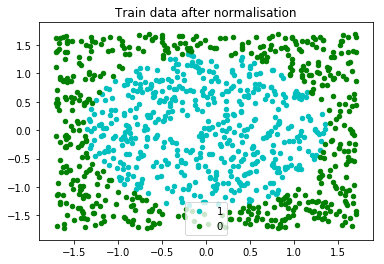

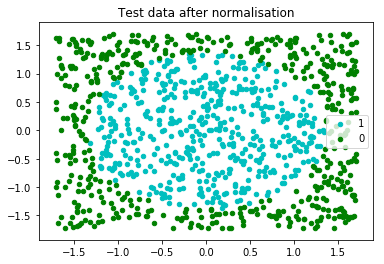

tensor([[-0.5764,  1.6366],
        [-1.3328,  1.2713],
        [-1.1714, -1.5047],
        [ 0.4748, -1.4259],
        [ 0.5148, -0.3062],
        [ 0.9893, -0.1912],
        [-1.3756, -1.1375],
        [ 1.0027, -1.3436],
        [ 1.5951, -1.3200],
        [-1.0700,  1.4118]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


In [17]:
plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target[:,1]==1),0] ,test_input[(test_target[:,1]==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target[:,1]==0),0] ,test_input[(test_target[:,1]==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


print(train_input[0:10,:])
print(train_target[0:10,:])

hidden_nb = 25

### With autograd

In [18]:
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F

torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

class Net(nn.Module):
    def __init__(self, hidden_neurons = 25):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc4 = nn.Linear(hidden_neurons, 2)

    def forward(self, x):
        x_0 = F.relu(self.fc1(x))
        x_1 = F.relu(self.fc2(x_0))
        x_2 = F.relu(self.fc3(x_1))
        x_3 = self.fc4(x_2)
        y = (x_0, x_1, x_2, x_3)
        return y

model, criterion = Net(), nn.CrossEntropyLoss()

true_output = model(train_input)
true_loss = criterion(true_output[3], train_target.argmax(dim=1))
print("Loss: ", true_loss.item())
#print(true_output[3][0:10,:])

model.zero_grad()
#true_loss.backward()
# print(model.fc1.bias)
# print(torch.autograd.grad(true_loss, true_output[3]))
print(torch.autograd.grad(true_loss, model.fc3.weight))

torch.set_grad_enabled(False)


Loss:  0.6957371830940247
(tensor([[-1.4765e-04, -2.8025e-04, -3.5486e-03, -9.5931e-04,  0.0000e+00,
         -1.7778e-05, -2.4884e-04,  0.0000e+00,  0.0000e+00, -2.6968e-04,
         -3.2092e-04, -9.1408e-04, -7.2274e-04,  0.0000e+00,  0.0000e+00,
         -7.0860e-04,  0.0000e+00, -1.8385e-03,  0.0000e+00, -1.7961e-03,
         -9.9343e-04, -3.2271e-03, -1.0846e-03, -1.5831e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.6481e-05, -1.4055e-04, -7.3719e-04,  0.0000e+00, -1.9927e-03,
         -1.6315e-03,  0.0000e+00, -1.3212e-03, -1.1047e-03,  0.0000e+00,
          0.0000e+00, -2.6185e-03, -2.7762e-05, -3.5747e-04, -9.9597e-04,
         

### Without autograd

In [19]:




linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = CrossEntropy()


# linear_1.normalize_parameters(mean=1, std=2)
# linear_2.normalize_parameters(mean=1, std=2)
# linear_3.normalize_parameters(mean=1, std=2)
# linear_4.normalize_parameters(mean=1, std=2)

linear_1.define_parameters(model.fc1.weight, model.fc1.bias)
linear_2.define_parameters(model.fc2.weight, model.fc2.bias)
linear_3.define_parameters(model.fc3.weight, model.fc3.bias)
linear_4.define_parameters(model.fc4.weight, model.fc4.bias)



def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    #relu_4.forward(
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    print("loss: ", l.item(), "\n")
    return x  
    
our_output = model_forward(train_input, train_target.argmax(dim=1))


## MODEL BACKWARD PASS
def model_backward():
    grad = loss.backward()
    print(grad)
    #grad = relu_4.backward(grad)
    grad = linear_4.backward(grad)
    #print(grad.t())
    grad = relu_3.backward(grad)
    grad = linear_3.backward(grad)
    #print(grad.size())
    grad = relu_2.backward(grad)
    grad = linear_2.backward(grad)
    #print(grad.size())
    grad = relu_1.backward(grad)
    grad = linear_1.backward(grad)
    #print(grad.size())
    return(grad)

grad = model_backward()

#print(true_output[3][0:4,:])
print(linear_3.gradwrtweight)


loss:  0.6957371830940247 

tensor([[-0.0004,  0.0004],
        [-0.0004,  0.0004],
        [-0.0004,  0.0004],
        ...,
        [-0.0004,  0.0004],
        [ 0.0006, -0.0006],
        [ 0.0006, -0.0006]])
tensor([[-1.4765e-04, -2.8025e-04, -3.5486e-03, -9.5931e-04,  0.0000e+00,
         -1.7778e-05, -2.4884e-04,  0.0000e+00,  0.0000e+00, -2.6968e-04,
         -3.2092e-04, -9.1408e-04, -7.2274e-04,  0.0000e+00,  0.0000e+00,
         -7.0860e-04,  0.0000e+00, -1.8385e-03,  0.0000e+00, -1.7961e-03,
         -9.9343e-04, -3.2271e-03, -1.0846e-03, -1.5831e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.6481e-05, -1.4055e-04, -7.3719e-04, 

In [172]:
print(true_output[3][0:3,:])
print(our_output[0:3,:])

tensor([[ 0.0394, -0.0420],
        [ 0.0224, -0.0567],
        [ 0.0506, -0.0481]], requires_grad=True)
tensor([[ 0.0394, -0.0420],
        [ 0.0224, -0.0567],
        [ 0.0506, -0.0481]])


In [ ]:
print(linear_4.weight.size())
print(linear_4.gradwrtweight.size())

In [21]:
print(train_target.size())

torch.Size([1000, 2])
